# (20) Load and plot readout results

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Load

In [2]:
from base.utils_model import load_model

tr, metadata = load_model(
    model_name='fixate1_k-32_z-13x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)',
    fit_name='ep400-b1000-lr(0.002)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)_(2023_04_15,21:35)',
    device='cpu', # 'cuda',
    checkpoint=-1,
)
print(f"'checkpoint': {metadata['checkpoint']}")

'checkpoint': 400

In [4]:
# grads = metadata['stats']['grad']

In [5]:
# plt.semilogy(grads.keys(), grads.values(), marker='.');

In [5]:
thresholds = [
    tr.cfg.grad_clip * i for i in
    [1, 2, 5, 10, 20, 50, 100, 200]
]
bad = np.array(list(grads.values()))

t = PrettyTable(['Threshold', '#', '%'])
for thres in thresholds:
    tot = (bad > thres).sum()
    perc = tot / metadata['global_step']
    perc = np.round(100 * perc, 3)
    t.add_row([thres, tot, perc])
print(t, '\n')

+-----------+-----+-------+
| Threshold |  #  |   %   |
+-----------+-----+-------+
|   400.0   | 511 | 0.608 |
|   800.0   |  30 | 0.036 |
|   2000.0  |  24 | 0.029 |
|   4000.0  |  22 | 0.026 |
|   8000.0  |  18 | 0.021 |
|  20000.0  |  15 | 0.018 |
|  40000.0  |  14 | 0.017 |
|  80000.0  |  12 | 0.014 |
+-----------+-----+-------+

In [6]:
nf = sum(tr.model.ftr_sizes()[0].values())
nf

2752

## Load Readout

In [6]:
fit_name = 'fixate1_nf-2752_(2023_04_20,19:16)'
path = pjoin(tr.model.cfg.results_dir, 'Ridge', fit_name)

In [7]:
perf_raw, perf_all, alpha_all = [], [], []
pix_ranks, pix_counts = [], []
for f in tqdm(sorted(os.listdir(path))):
    if not f.endswith('.pkl'):
        continue
    root = f.split('.')[0]
    root, expt = root.split('-')
    kws = dict(
        tr=tr,
        root=root,
        expt=expt,
        verbose=False,
    )
    ro = Readout(**kws).load(fit_name, 'cuda:2')
    perf_raw.extend(list(ro.perf.values()))
    alpha_all.extend([m.alpha for m in ro.mod.values()])

    if ro.max_perf is not None:
        for i, r in ro.perf.items():
            perf_all.append(r / ro.max_perf[i])
    else:
        perf_all.extend(list(ro.perf.values()))
    
    # pixel stuff
    for idx, best in ro.best_pix.items():
        rank = np.where(np.all(
            ro.sorted_pix[idx] == best,
            axis=1
        ))[0][0]
        count = collections.Counter([
            tuple(e) for e in
            ro.best_pix_all[idx]
        ])
        count = count.get(best, 0)

        pix_ranks.append(rank) 
        pix_counts.append(count)

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 101.15it/s]


In [8]:
len(perf_all), np.mean(perf_raw), np.mean(perf_all)

(5, 0.35037239953398946, 0.35037239953398946)

In [9]:
perf_all

[0.13161761655338194,
 0.29448376830763395,
 0.3702581506090746,
 0.4104967780190537,
 0.5450056841808034]

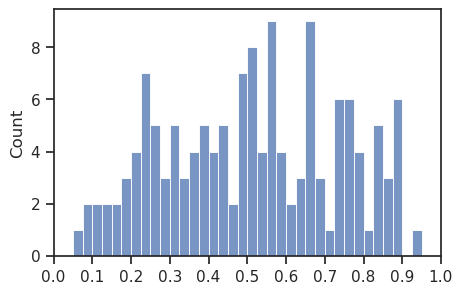

In [25]:
ax = sns.histplot(perf_all, bins=np.linspace(0, 1, 41))
ax.locator_params(axis='x', nbins=10)
ax.set(xlim=(0, 1));

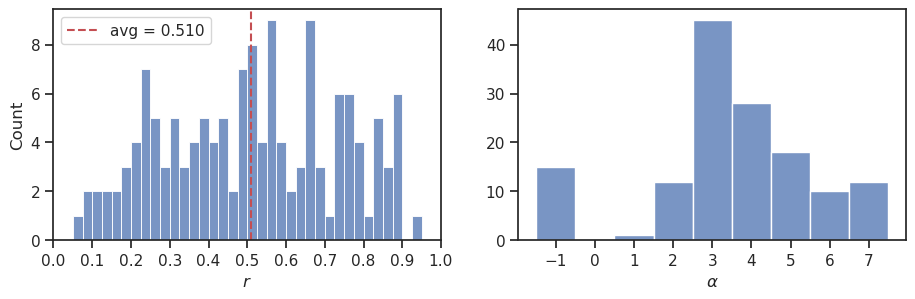

0.5104418015793724

In [26]:
fig, axes = create_figure(1, 2, (11, 3))
sns.histplot(perf_all, bins=np.linspace(0, 1, 41), ax=axes[0])
avg = np.mean(perf_all)
axes[0].axvline(avg, color='r', ls='--', label=f"avg = {avg:0.3f}")
axes[0].locator_params(axis='x', nbins=10)
axes[0].set(xlabel=r'$r$')
axes[0].legend()
axes[0].set_xlim(0, 1)

sns.histplot(np.log10(alpha_all), bins=np.linspace(-1, 8, 10) - 0.5, ax=axes[1])
axes[1].locator_params(axis='x', nbins=10)
axes[1].set(ylabel='', xlabel=r'$\alpha$')

plt.show()

avg

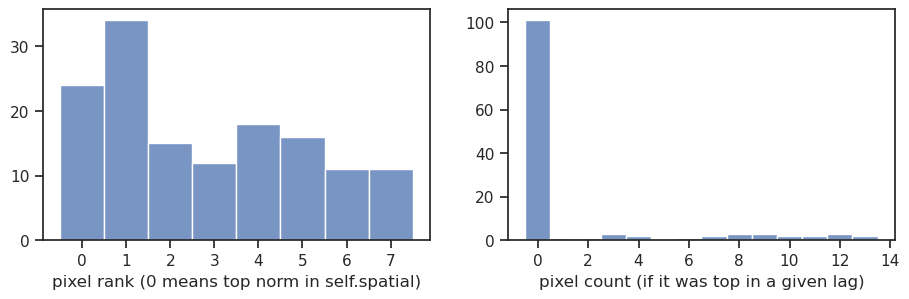

In [27]:
fig, axes = create_figure(1, 2, (11, 3))

sns.histplot(pix_ranks, bins=np.linspace(0, 8, 9) - 0.5, ax=axes[0])
axes[0].locator_params(axis='x', nbins=10)
axes[0].set(ylabel='', xlabel='pixel rank (0 means top norm in self.spatial)')

sns.histplot(pix_counts, bins=np.linspace(0, 14, 15) - 0.5, ax=axes[1])
axes[1].locator_params(axis='x', nbins=15)
axes[1].set(ylabel='', xlabel='pixel count (if it was top in a given lag)')

plt.show()

In [34]:
best_lag_all = []
for f in tqdm(sorted(os.listdir(path))):
    if not f.endswith('.pkl'):
        continue
    root = f.split('.')[0]
    root, expt = root.split('-')
    kws = dict(
        tr=tr,
        root=root,
        expt=expt,
        verbose=False,
    )
    ro = Readout(**kws).load(fit_name, 'cuda:2')
    best_lag_all.extend(list(ro.best_lags))

100%|██████████| 61/61 [00:02<00:00, 28.95it/s] 


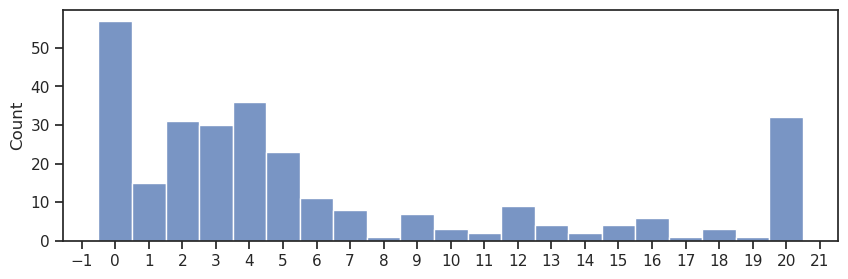

In [51]:
fig, ax = create_figure(1, 1, (10, 3))
sns.histplot(best_lag_all, bins=np.linspace(0, 21, 22) - 0.5, ax=ax)
ax.locator_params(axis='x', nbins=24)

In [52]:
ro.name()

'YUWEI-ytu029'

In [53]:
ro.perf

{0: 0.1040044907322527,
 1: 0.4360466153773416,
 2: 0.31633306447742704,
 3: 0.3544574026497518,
 4: 0.8206905335123917,
 5: 0.2828317705477584,
 6: 0.31989903465936664,
 7: 0.14737506487696467,
 8: 0.5534566705626145,
 9: 0.48721576839402975,
 12: 0.14246210802680204,
 13: 0.12138484194414599,
 15: 0.5397319499437503,
 16: 0.42146193141461,
 17: 0.4852431609643415,
 18: 0.1944878144793781,
 19: 0.3499528197332127,
 20: 0.2323178544653955,
 21: 0.1611313238266908,
 22: 0.6407801728198075,
 23: 0.697364118530261}

In [60]:
ro.best_lags

array([11,  0, 20, 12,  2,  0,  3, 20,  2,  2, 20, 20, 20, 20,  2,  0,  6,
        4, 15,  0,  2, 15,  5,  3])

In [62]:
np.mean(list(ro.perf.values()))

0.3718394529494426

In [65]:
ro.max_perf

array([0.33108475, 0.87946936, 0.66127801, 0.66874722, 0.93558345,
       0.50904479, 0.62691563, 0.50264635, 0.84960201, 0.79756451,
       0.87772498, 0.90904363, 0.32449578, 0.26745876, 0.89406833,
       0.8621174 , 0.94587316, 0.94132411, 0.9341642 , 0.94125361,
       0.95839459, 0.84670991, 0.93003266, 0.9468225 ])

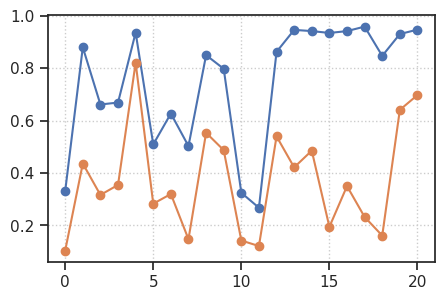

In [74]:
plt.plot(ro.max_perf[list(ro.perf)], marker='o')
plt.plot(ro.perf.values(), marker='o')
plt.grid();

In [76]:
ro.best_lags[13], ro.perf[13]

(20, 0.12138484194414599)

In [58]:
np.logspace(-1, 7, num=9)

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])

In [4]:
fit_name = "fixate1_nf-2752_(2023_04_20,18:54)/Trainer"

In [5]:
os.listdir(fit_name)

FileNotFoundError: [Errno 2] No such file or directory: 'fixate1_nf-2752_(2023_04_20,18:54)/Trainer'